In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt

In [2]:
import torch
import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision.transforms import functional as F

In [3]:
from data_utils.wider_dataset import *
from data_utils.wider_eval import *
from data_utils.data_read import *
from model.model_utils import *

In [4]:
def imshow(img, bboxes=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img, aspect='equal')
    
    if bboxes is not None:
        for bbox in bboxes:
            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='red', linewidth=3.5)
                )

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
wider_img_list, wider_bboxes = wider_read(100)

In [7]:
train_dataset = WiderDataset(wider_img_list[:90], wider_bboxes[:90])
test_dataset = WiderDataset(wider_img_list[90:], wider_bboxes[90:])
train_loader = DataLoader(train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)
test_loader = DataLoader(test_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (face) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [12]:
backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet18', True)
model.backbone = backbone

In [13]:
model.load_state_dict(torch.load('./saved_models/fasterrcnn_resnet18_fpn3.pth'))

<All keys matched successfully>

In [14]:
images, targets = next(iter(train_loader))


In [11]:
%%time
start = time.time()

prediction_info = []
target_info = []
model.eval()

for images, targets in test_loader:

    images = list(F.to_tensor(image) for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)
    prediction_info.append(predictions)
    target_info.append(targets)
#     print(len(predictions[0]['scores']))

end = time.time()
print(f"Time elapsed in Predicting: {end-start:.2f}")


prediction_info = list(itertools.chain(*prediction_info))
target_info = list(itertools.chain(*target_info))

Time elapsed in Predicting: 41.16
CPU times: user 40.2 s, sys: 6.64 s, total: 46.8 s
Wall time: 41.2 s


In [12]:
r = evaluation(prediction_info, target_info, iou_thresh=0.3, interpolation_method='EveryPoint')
print(r['AP'])

Processing : 100%|██████████| 10/10 [00:00<00:00, 79.13it/s]

0.8473866925812935


In [ ]:
PlotPrecisionRecallCurve(r)

In [18]:

images, targets = next(iter(test_loader))

# images = list(F.to_tensor(image) for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]


In [19]:
image = np.zeros(1)

In [22]:
images[0].shape

(832, 1024, 3)

In [23]:
image = np.array([images[0]])

In [12]:
# images = np.stack([images[0], images[0]], axis=0).astype(np.float32)

In [13]:
images.shape

(2, 683, 1024, 3)

In [ ]:
# from advertorch.attacks import GradientAttack

# images = torch.tensor(list(F.to_tensor(image) for image in images))
# targets = [{k: v for k, v in t.items()} for t in targets]

# adversary = GradientAttack(
#     model, eps=0.3, targeted=False)

# adv_untargeted = adversary.perturb(images[0][:,:,(2,1,0)].reshape(1,3,768,1024), targets[0])

In [24]:
# from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch, ProjectedGradientDescent, CarliniL2Method, AutoProjectedGradientDescent, AutoAttack
from art.attacks.evasion import *
from art.estimators.object_detection import PyTorchFasterRCNN

In [25]:
detector = PyTorchFasterRCNN(model=model, clip_values=(0,1), preprocessing=None)

In [ ]:
# detector.predict(images)

In [41]:
# Step 6: Generate adversarial test examples
# attack = FastGradientMethod(estimator=detector, eps=0.05, eps_step=0.01)
attack = ProjectedGradientDescent(detector, eps=0.01, eps_step=0.009, max_iter=10, verbose=True)
# attack = ShapeShifter(detector)
x_test_adv = attack.generate(x=image, y=None)

# Step 7: Evaluate the ART classifier on adversarial test examples

# predictions = classifier.predict(x_test_adv)
# accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
# print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))


x_test_adv

imshow(images[0])

imshow(x_test_adv[0])

In [42]:
adv_det = detector.predict(x_test_adv)
org_det = detector.predict(np.array(image))

In [43]:
box_filter = org_det[0]['scores'] > 0.7

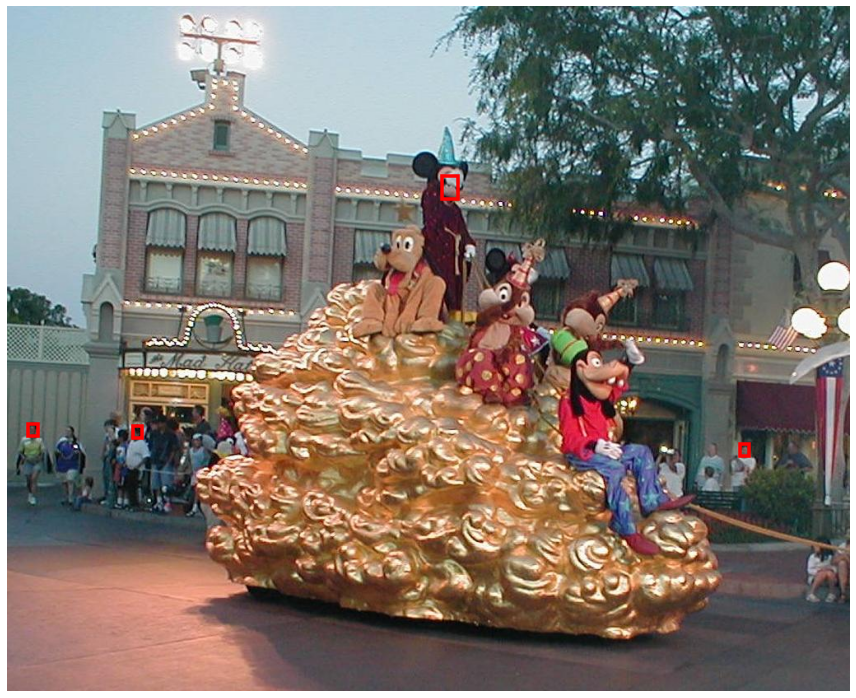

In [33]:
imshow(images[0],org_det[0]['boxes'][box_filter])

In [46]:
adv_box_filter = adv_det[0]['scores'] > 0.95

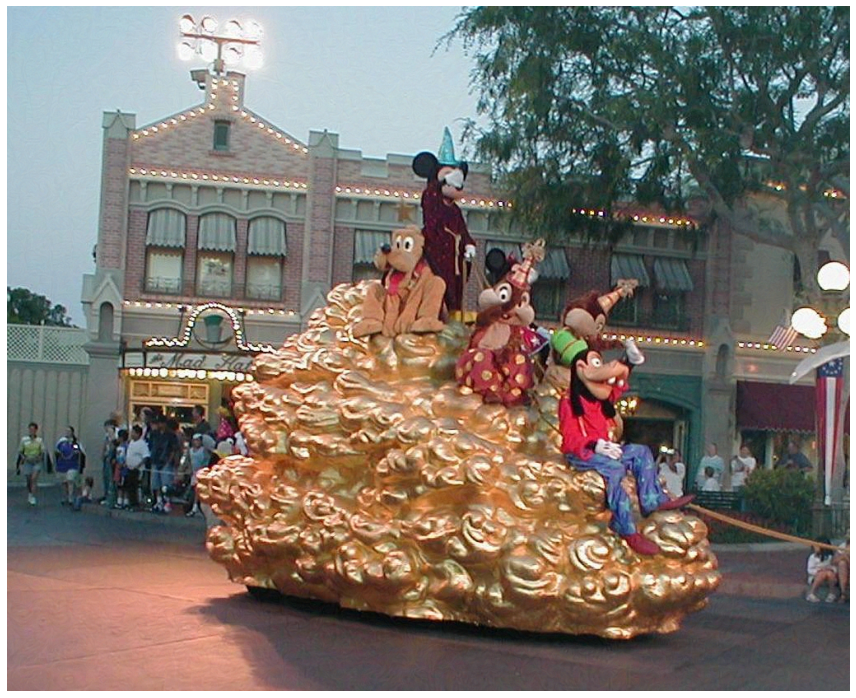

In [47]:
imshow(x_test_adv[0],adv_det[0]['boxes'][adv_box_filter])

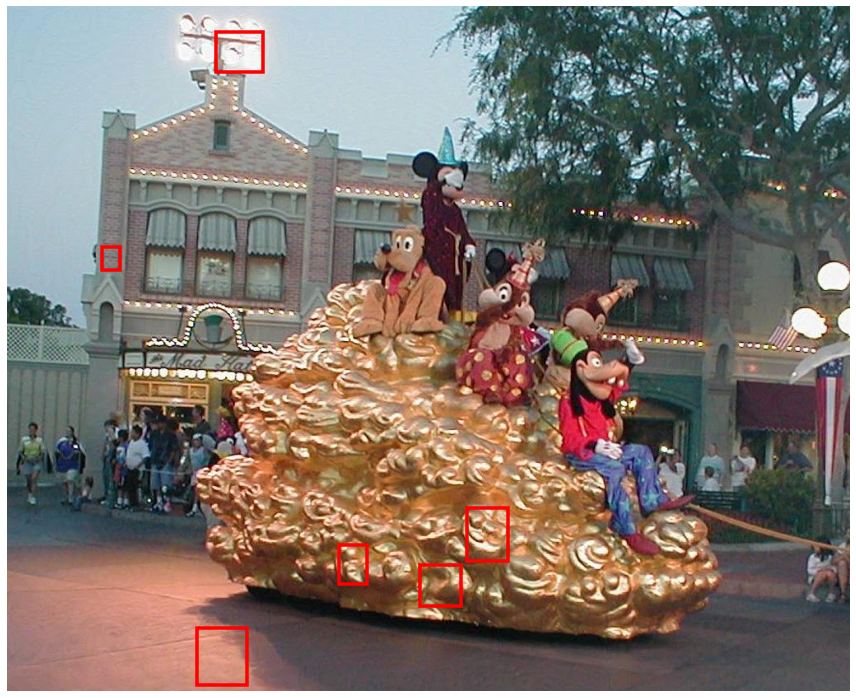

In [35]:
imshow(x_test_adv[0],adv_det[0]['boxes'][adv_box_filter])